<center><img alt="" src="images/tau-data_banner.png"/></center>
<center><strong><h1>HPDS-04: GPU Parallel Programming via Python</h1></strong><br />
<img alt="" src="images/PDS_logo.jpg" />

## (C)Taufik Sutanto
## https://tau-data.id/hpds-04/

# Outline:

*  Instalasi
* Pendahuluan GPU Programming
* GPU Programming Dasar
* Contoh Kasus 1
* Contoh Kasus 2

In [16]:
from IPython.display import HTML, IFrame 
from numba import cuda, vectorize, guvectorize
from numba import void, uint8 , uint32, uint64, int32, int64, float32, float64, f8
import numpy as np, numba

# Instalasi (Local)

* pip install Numba
* Installl CudaToolkit: https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows/index.html
* CUDA_HOME=C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v10.1
* https://web.facebook.com/groups/datamining.indonesia/permalink/1292026854338520

## Di Google Colab jangan lupa mengganti "RunTime Type" dari None ke GPU

<img alt="" src="images/motherboard.png" />

* Image Source: https://en.wikipedia.org/wiki/GPU_switching

# More Processors in our Computer

<img alt="" src="images/cpu_gpu.jpg" />

* image source: http://www.frontiersin.org/files/Articles/70265/fgene-04-00266-HTML/image_m/fgene-04-00266-g001.jpg
* Graphics Card (misal Nvidia) memiliki banyak prosesor yang biasanya digunakan untuk kepentingan "display".
* Prosesor ini dapat diakses untuk melakukan beberapa komputasi sederhana.
* Untuk GPU Programming saat ini hanya disupport oleh Nvidia (AMD, Intel, dsb belum mendukung/tidak ada library-nya).
* CPU VS GPU: https://youtu.be/-P28LKWTzrI?t=64
<img alt="" src="images/cpu_thread_gpu.png" />


<img alt="" src="images/how-gpu-acceleration-works.png" />

* Image source: http://www.nvidia.com/docs/IO/143716/how-gpu-acceleration-works.png

<img alt="" src="images/CUDA_processing_flow_(En).png" />

* Image Source: http://upload.wikimedia.org/wikipedia/commons/thumb/5/59/CUDA_processing_flow_%28En%29.PNG/450px-CUDA_processing_flow_%28En%29.PNG
* More here: http://selkie.macalester.edu/csinparallel/modules/GPUProgramming/build/html/Introduction/Introduction.html

In [9]:
from numba import cuda

cc_cores_per_SM_dict = {
    (2,0) : 32,
    (2,1) : 48,
    (3,0) : 192,
    (3,5) : 192,
    (3,7) : 192,
    (5,0) : 128,
    (5,2) : 128,
    (6,0) : 64,
    (6,1) : 128,
    (7,0) : 64,
    (7,5) : 64,
    (8,0) : 64
    }
device = cuda.get_current_device()
my_sms = getattr(device, 'MULTIPROCESSOR_COUNT')
my_cc = getattr(device, 'COMPUTE_CAPABILITY')
cores_per_sm = cc_cores_per_SM_dict.get(my_cc)
total_cores = cores_per_sm*my_sms
print("GPU compute capability: " , my_cc)
print("GPU total number of SMs: " , my_sms)
print("total cores: " , total_cores)

GPU compute capability:  (6, 1)
GPU total number of SMs:  3
total cores:  384


# Performance tuning: GPU Programming via Numba

* Memory GPU biasanya lebih terbatas dan transfer memory antar main memory dan GPU memory biasanya relatif lambat.
* Sehingga hanya lakukan GPU programming pada fungsi sangat computationally expensive.

In [6]:
# TIDAK UNTUK DIJALANKAN di Google Colab
# Contoh untuk menjalankan di Local

from timeit import default_timer as timer
import os
import numpy as np
from numba import jit, cuda
import warnings
warnings.simplefilter('ignore')

# normal function to run on cpu
def func(a):
    for i in range(10000000):
        a[i] += 1

# function optimized to run on gpu
@jit(target="cuda")
def func2(a):
    for i in range(10000000):
        a[i] += 1

if __name__ == "__main__":
    os.environ['NUMBAPRO_NVVM'] = r'C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v10.1\nvvm\bin\nvvm64_33_0.dll'
    os.environ['NUMBAPRO_LIBDEVICE'] = r'C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v10.1\nvvm\libdevice'

    n = 10000000
    a = np.ones(n, dtype=np.float64)
    b = np.ones(n, dtype=np.float32)

    start = timer()
    func(a)
    print("without GPU:", timer()-start)

    start = timer()
    func2(a)
    print("with GPU:", timer()-start)

without GPU: 7.9465406
with GPU: 1.5789905000000006


# Contoh MandelBrot

## Pure Python

In [10]:
def mandel(x, y, max_iters):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if z.real*z.real + z.imag*z.imag >= 4:
            return i
    return max_iters

def create_fractal(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape

    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height

    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x]  = color

Mandelbrot created on CPU in 27.224164 s


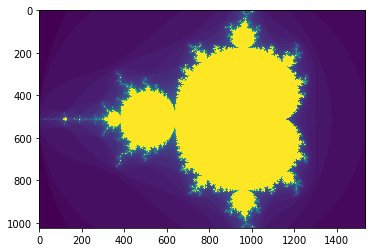

In [13]:
import matplotlib.pyplot as plt

gimage = np.zeros((1024, 1536), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50

start = timer()
create_fractal(xmin, xmax, ymin, ymax, gimage, iters)
dt = timer() - start

print("Mandelbrot created on CPU in %f s" % dt)
plt.imshow(gimage);

# Contoh MandelBrot

## JIT Numba

In [19]:
mandel_numba = numba.jit()(mandel)

In [20]:
@numba.jit
def create_fractal_numba(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape

    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height

    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            color = mandel_numba(real, imag, iters)
            image[y, x]  = color

Mandelbrot created on CPU in 0.483938 s


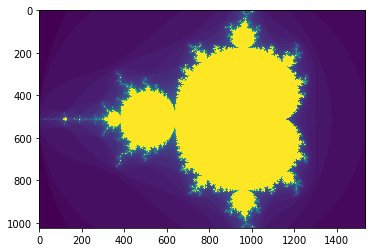

In [22]:
gimage = np.zeros((1024, 1536), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50

start = timer()
create_fractal_numba(xmin, xmax, ymin, ymax, gimage, iters)
dt = timer() - start

print("Mandelbrot created on CPU in %f s" % dt)
plt.imshow(gimage);

# Contoh MandelBrot

## GPU Numba

In [23]:
mandel_gpu = cuda.jit(device=True)(mandel)

In [24]:
@cuda.jit(argtypes=[float32, float32, float32, float32, uint8[:,:], uint32])
def create_fractal_kernel(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape

    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height

    startX, startY = cuda.grid(2)
    gridX = cuda.gridDim.x * cuda.blockDim.x # stride in x
    gridY = cuda.gridDim.y * cuda.blockDim.y # stride in y

    for x in range(startX, width, gridX):
        real = xmin + x*pixel_size_x
        for y in range(startY, height, gridY):
            imag = ymin + y*pixel_size_y
            color = mandel_gpu(real, imag, iters)
            image[y, x]  = color

Mandelbrot created on GPU in 0.020478 s


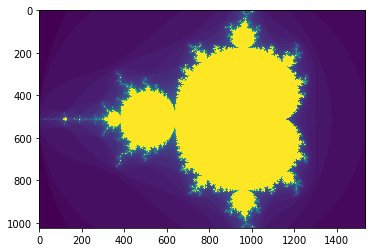

In [25]:
gimage = np.zeros((1024, 1536), dtype=np.uint8)
blockdim = (32, 8)
griddim = (32, 16)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50

start = timer()
d_image = cuda.to_device(gimage)
create_fractal_kernel[griddim, blockdim](xmin, xmax, ymin, ymax, d_image, iters)
d_image.to_host()
dt = timer() - start

print("Mandelbrot created on GPU in %f s" % dt)
plt.imshow(gimage);

# More Explanation/Reference:

* https://pyvideo.org/pycon-us-2019/cuda-in-your-python-effective-parallel-programming-on-the-gpu.html
* https://nyu-cds.github.io/python-numba/05-cuda/
* https://people.duke.edu/~ccc14/sta-663/CUDAPython.html

# End of Module

<hr>
<img alt="" src="images/.png"/>